# FEniCS simulation of a cantilever beam

The aim of this notebook is to setup a very simple FEniCS simulation. The framework is linear, plane strain elasticity. We model a cantilever beam ($L$: total length; $d$: depth), subjected to its own weight ($\rho$: mass density per unit volume; $g$: gravity).

The beam is homogenous and isotropic ($E$: Young modulus; $\nu$: Poisson ratio) and clamped on the left end. Hooke's law reads

$$
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
$$

where indices $i, j, k$ are restricted to $\{1, 2\}$ and $\lambda$, $\mu$ are the Lamé coefficients :

$$
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
$$

**Question:** how does Hooke's law read in *plane stress* elasticity?

The variational formulation of the problem is the following:

Find $u\in \mathcal{C}\equiv\{u: H^1(\Omega), \; u(x_1=0,x_2)=0\}$ such that 
$\forall v\in \mathcal{C}_0\equiv \mathcal{C}$


$$
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y =
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y,
$$

where $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$  

Remark: we work with only one unknown vector field, the displacement $u_x(x_1,x_2)$

![image of beam](cantilever_beam.png "Cantilever beam")

In [1]:
import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
from ufl import nabla_grad
from ufl import nabla_div

## 1) Start with defining the mesh

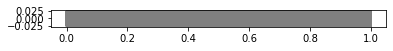

In [26]:
# geometry and mesh 
L = 1. # total length
d = L/20. # thickness
h = d/16. # size of a cell

mesh = dl.RectangleMesh(dl.Point(0, -d/2), dl.Point(L, d/2), int(L/h), int(d/h))
dl.plot(mesh)

use

```
RectangleMesh()

plot(mesh)
```

## 2) Choose an element (Lagrange of degree 1)

In [3]:
V = dl.VectorFunctionSpace(mesh, 'P', 1)

use

```
FunctionSpace( )
```

or ? 

```
VectorFunctionSpace( )
```

## 3) Define the stress

$u_i$ is  the displacement vector (note: $u=u(x_1,x_2)$)

and 

$\epsilon_{ij} = \frac12\bigl(\partial_i u_j+\partial_j u_i\bigr)$ is the stress tensor.

In [5]:
# use def to define the fonction epsilon = epsilon(u), just like


def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

## 4) Write down Hooke's law

In [6]:
# here we use the values
E = 1.0
nu = 0.3
mu_ = E/(2*(1+nu))
lambda_ = E*nu/((1+nu)*(1-2*nu))

# Hook's law is written as the top of this notebook
def sigma(u):
    return lambda_*nabla_div(u)*dl.Identity(d) + 2*mu_*epsilon(u)

## 5) Name `u` the `TrialFunction` and `v` the `TestFunction`

In [7]:
# Define variational problem
u = dl.TrialFunction(V)
v = dl.TestFunction(V)
d = u.geometric_dimension()  # space dimension

NablaGrad(Argument(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 1, None))

## 6) Introduce the bilinear form
$$
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y
$$

What is the difference between `dolfin.dot( )` and `dolfin.inner( )` ?

In [9]:
a = dl.inner(sigma(u), epsilon(v))*dl.dx

## 7) Introduce the linear form

$$
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y.
$$

In [25]:
# here we use the value
g = 1.0
rho = 1.0
f = dl.Constant((0, -rho*g))
b = dl.dot(f, v)*dl.dx 

## 8)  Boundary conditions

Dirichelet Boundary Condition: $u(0,x_2)=0 \quad  \forall x_2 \in [-\frac{d}{2},\frac{d}{2}]$

As $x_1=0$ is not well defined in our mesh, we write 

$u(x_1,x_2)=0 \quad \forall x_1 \ll L  \text{ and } \forall x_2 \in [-\frac{d}{2},\frac{d}{2}]$


In [17]:
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] == 0

bc = dl.DirichletBC(V, dl.Constant((0, 0)), clamped_boundary)

## 9) Solving the discretized problem

In [15]:
# We introduce the solution we are looking as a Function 
#
usol = dl.Function(V)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [27]:
# And we solve the linear problem using 
#
dl.solve(a == b, usol, bc)

## 10) Using linear beam theory, we plot the vertical deflection of the solution 

$$H(x_1)=u_2(x_1,0)$$

In [19]:
# we introduce the coefficients
D=E*d**3/12./(1.-nu**2) # bending rigidity of an elastic plate
k=0.2 # unknown coefficient that we want to find (it is not equal to 0.2)
Hmax = k*g*d/D # maximum vertical deflection, from linear 'beam' theory 

$$ H(x_1) = H_\text{max} \, \left ( - \frac{1}{3} \, (x_1-1)^4 - \frac{4}{3} \, x_1 + \frac{1}{3} \right) $$

In [20]:
Hmax

873.5999999999999

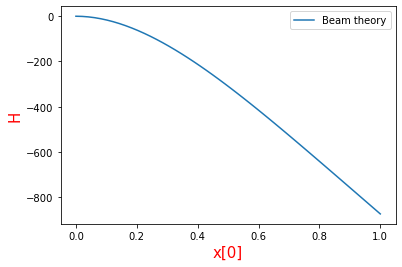

In [33]:
x = np.linspace(0, L, num=50)
H_formula = Hmax * (-1./3.*(x-1.)**4 - 4./3.*x + 1/3)

plt.plot(x, H_formula, label='Beam theory')
plt.xlabel('x[0]',color='red',fontsize=15)
plt.ylabel('H',color='red',fontsize=15)
plt.legend()

## 11) On this plot, we add the plot of the numerically found  $u_2(x_1,0)$ and we change the value of $k$ for the two plots to coincide

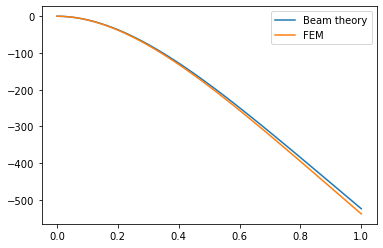

In [83]:
k=0.12 # unknown coefficient that we want to find (it is not equal to 0.2)
Hmax = k*g*d/D # maximum vertical deflection, from linear 'beam' theory 
H_formula = Hmax * (-1./3.*(x-1.)**4 - 4./3.*x + 1/3)

u2 = []
for x0 in x: 
    u2.append(usol(x0,0)[1])

# dl.plot(usol, mode='displacement')
plt.plot(x, H_formula, label='Beam theory')
plt.plot(x, u2, label='FEM')
plt.legend()


## 12) We plot the deformed beam, hanging under its own weight

Calling FFC just-in-time (JIT) compiler, this may take some time.


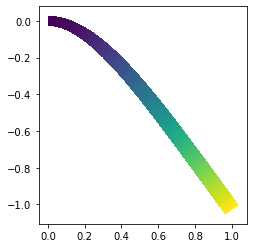

In [84]:
# instead of plotting usol, we plot usol/Hmax with the correct value of k
dl.plot(usol/Hmax, mode='displacement')

In [86]:
usol(L, 0)


array([-2.92723129e-03, -5.38249432e+02])

In [112]:
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    # Hook's law is written as the top of this notebook
d = 2
nu = 0.3
g = 1.0
rho = 1.0
f = dl.Constant((0, -rho*g))

def sigma(u, lambda_, mu_):
    return lambda_*nabla_div(u)*dl.Identity(d) + 2*mu_*epsilon(u)

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] == 0

def fleche_FEM(L=1, d=1/20., E=1):
    # geometry and mesh 
    # L = 1. # total length
    # d = L/20. # thickness
    h = d/16. # size of a cell

    mesh = dl.RectangleMesh(dl.Point(0, -d/2), dl.Point(L, d/2), int(L/h), int(d/h))
    V = dl.VectorFunctionSpace(mesh, 'P', 1)

    # E = 1.0

    mu_ = E/(2*(1+nu))
    lambda_ = E*nu/((1+nu)*(1-2*nu))

    u = dl.TrialFunction(V)
    v = dl.TestFunction(V)
    # d = u.geometric_dimension()  # space dimension

    a = dl.inner(sigma(u, lambda_, mu_), epsilon(v))*dl.dx

    # here we use the value

    b = dl.dot(f, v)*dl.dx 

    bc = dl.DirichletBC(V, dl.Constant((0, 0)), clamped_boundary)

    usol = dl.Function(V)
    dl.solve(a == b, usol, bc)
    return usol(L, 0)[0]



In [113]:
E = np.arange(0.5, 10, 0.5)
fleche_E = np.zeros(E.shape[0])
for i, e in enumerate(E):
    fleche_E[i] = fleche_FEM(E=e)


In [119]:
abs(fleche_E)

array([0.00585497, 0.00292723, 0.00195164, 0.0014635 , 0.00117084,
       0.00097572, 0.00083643, 0.00073187, 0.00065054, 0.00058547,
       0.00053222, 0.00048789, 0.00045038, 0.00041821, 0.00039027,
       0.0003659 , 0.0003444 , 0.00032527, 0.00030814])

<function matplotlib.pyplot.loglog(*args, **kwargs)>

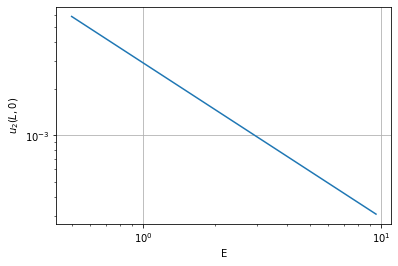

In [120]:
plt.loglog(E, abs(fleche_E))
plt.xlabel('E')
plt.ylabel(r'$u_2(L, 0)$')
plt.grid()
plt.loglog